# Predicting Air-bnb Prices

*Nicholas Presnar* - 100% contribution

## Part 1: Introduction

The bustling real estate market in New York City has long been a focal point of interest for homeowners, investors, and tourists alike. With its diverse neighborhoods, myriad property types, and a plethora of amenities, understanding the dynamics of pricing in this vibrant market can be both challenging and rewarding.

In this project, we aim to delve into the realm of data science and machine learning to tackle the intriguing question of predicting Airbnb listing prices in New York City. By leveraging a comprehensive dataset containing information on neighborhood characteristics, property types, room types, and other relevant features, our goal is to develop a predictive model that can assist homeowners in pricing their listings accurately.

#### Why predict Airbnb prices?

The goal for this project is to create a model and analysis that could in theory be used by owners looking to rent out their properties on Airbnb. We will be able to predict a price point based on several parameters / characteristics of the property. This project is aimed at properties intended for use by tourists to the city rather than any long-term rental properties.



##### Required libraries

Python libraries used:
- numpy
- matplotlib
- scipy
- sklearn
- folium
- branca

### Data Source and Assumptions:

The data for this project is sourced from [Inside Airbnb](https://insideairbnb.com), an independent platform that compiles and analyzes public information extracted from the Airbnb website.
- Inside Airbnb ensures that only publicly available data is utilized, with no private information being accessed or utilized.
- Location information for listings is anonymized within a certain radius of the actual address to maintain privacy.
- Listings within the same building may appear dispersed on the map due to individual anonymization.
- The accuracy and availability of data depend on the practices of individual hosts, as some may not update their calendars regularly.

Despite these considerations, Inside Airbnb takes due care in processing and analyzing the data, providing a valuable resource for public analysis and community benefit.


The data was downloaded in CSV format from Inside Airbnb, enabling further analysis and modeling for this project.

#### Importing the data into pandas

We will store the data in an easy-to-use pandas dataframe. Below are a random sample of 5 rows of the dataframe showing relevant columns.

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import folium
from branca.colormap import linear



selected_columns = ['id', 'name', 'neighbourhood_cleansed', 'property_type', 'room_type',
                    'accommodates', 'bedrooms', 'price', 'number_of_reviews', 'review_scores_rating']

columns_of_interest = ['neighbourhood_cleansed', 'property_type', 'room_type', 'bedrooms', 'price']

airbnb_data = pd.read_csv("listings.csv")
airbnb_data[selected_columns].sample(frac=1).head()

,id,name,neighbourhood_cleansed,property_type,room_type,accommodates,bedrooms,price,number_of_reviews,review_scores_rating
3306,1043046,Rental unit in New York · ★4.90 · Studio · 1 b...,Chelsea,Entire rental unit,Entire home/apt,2,NaN,NaN,72,4.90
37211,821678072574201886,Rental unit in New York · Studio · 1 bed · 1 bath,Midtown,Entire rental unit,Entire home/apt,3,0.0,$110.00,1,5.00
35018,37743419,Rental unit in The Bronx · ★4.92 · 1 bedroom ·...,Tremont,Entire rental unit,Entire home/apt,2,1.0,$90.00,12,4.92
36030,48733636,Rental unit in New York · ★4.33 · Studio · 1 b...,Gramercy,Entire rental unit,Entire home/apt,2,0.0,$76.00,3,4.33
14408,4881420,Rental unit in New York · ★4.54 · Studio · 2 b...,Chelsea,Entire rental unit,Entire home/apt,2,0.0,$179.00,93,4.54


## Part 2: Preprocessing

Before we can analyze this data, we need to modify and filter it to only include usable and relevant data points.

First, we only want to consider properties with a minimum of 1 night. These properties are intended for tourists and properties intended for longer stay may be priced differently, skewing our data.

In [14]:
airbnb_data = airbnb_data[airbnb_data['minimum_nights'] == 1]

Next, to filter out fake or unrealistically priced listings, we will only consider properties that have been reviewed (aka stayed at).

In [15]:
airbnb_data = airbnb_data[airbnb_data['number_of_reviews'] > 0]

We will convert the price column into a numeric column so that quantitative statistical analysis can be performed on it. Additionaly, listings without price data will not be considered.

In [16]:
airbnb_data['price'] = airbnb_data['price'].replace('[\$,]', '', regex=True).astype(float)
airbnb_data = airbnb_data.dropna(subset=['price'])

Next, we will imputate missing data in the other columns. This involves filling missing spaces with a statistical descriptor of the data to retain the same distribution. Numerical columns will be filled in with the median of the column. Categorical columns will be filled in with the mode (most common value) of their respective columns.

Additionally, we have noticed that some properties are listed with 0 bedrooms but include the actuial number of bedrooms in the title. We will imputate properties with 0 bedrooms with the median number of bedrooms of rooms with the same room types and property types.

In [17]:
# Imputate missing values in numerical columns with median
numerical_columns = airbnb_data.select_dtypes(include=['float64', 'int64']).columns
airbnb_data[numerical_columns] = airbnb_data[numerical_columns].fillna(airbnb_data[numerical_columns].median())

# Imputate missing values in categorical columns with mode
categorical_columns = airbnb_data.select_dtypes(include=['object']).columns
airbnb_data[categorical_columns] = airbnb_data[categorical_columns].fillna(airbnb_data[categorical_columns].mode().iloc[0])

# Impute 0 bedrooms with median of room_type and property_type
airbnb_data['bedrooms'] = airbnb_data.apply(lambda row: row['bedrooms'] if row['bedrooms'] != 0 else airbnb_data[(airbnb_data['property_type'] == row['property_type']) & (airbnb_data['room_type'] == row['room_type'])]['bedrooms'].median(), axis=1)


Here is a sample of our dataset after preprocessing:

In [18]:
airbnb_data[columns_of_interest].sample(frac=1).head()

,neighbourhood_cleansed,property_type,room_type,bedrooms,price
18332,Canarsie,Entire guest suite,Entire home/apt,1.0,129.0
30383,Williamsburg,Room in hotel,Private room,1.0,335.0
16400,Hell's Kitchen,Room in hotel,Private room,1.0,160.0
33919,Midtown,Room in hotel,Private room,1.0,327.0
15361,Midtown,Entire rental unit,Entire home/apt,1.0,154.0


## Part 3: Analysis and visualizations

### Price distribution

Lets look at the distribution of prices. Because most prices are centered around low hundreds but can go up to around $10,000, the distribution is very skewed. This makes it hard to grasp a good idea of the dsitribution of the lower prices. To solve this problem, we will apply a log transform to the prices before graphing them.

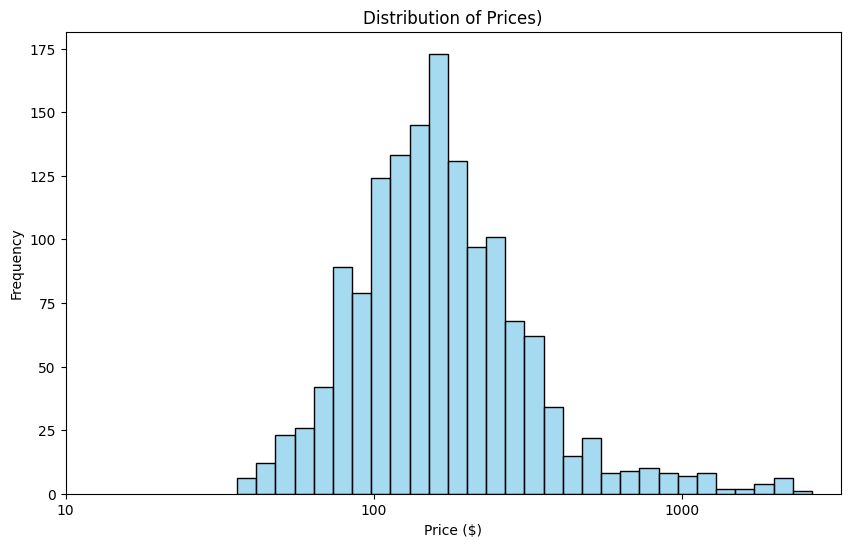

In [19]:
scaled_price = np.log10(airbnb_data['price'])

plt.figure(figsize=(10, 6))
sns.histplot(scaled_price, bins=30, kde=False, color='skyblue')
plt.title('Distribution of Prices)')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')

tick_positions = np.arange(np.floor(scaled_price.min()), np.floor(scaled_price.max()) + 1)
tick_labels = [int(10 ** i) for i in tick_positions]
plt.xticks(ticks=tick_positions, labels=tick_labels)

plt.show()

Below is the distribution of bedrooms. We can see that most listings have only one bedroom.

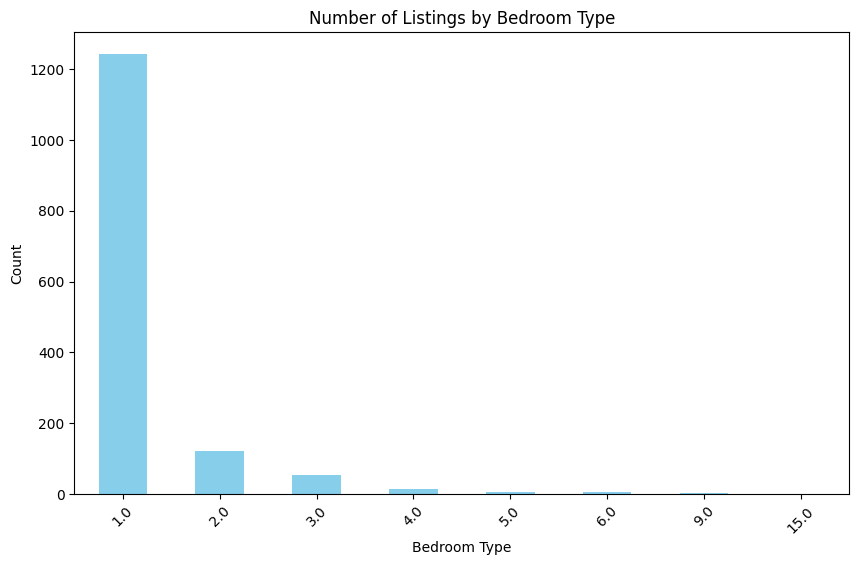

In [20]:
plt.figure(figsize=(10, 6))
airbnb_data['bedrooms'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Number of Listings by Bedroom Type')
plt.xlabel('Bedroom Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Next we will graph the distribution of prices for each number of bedrooms as a boxplot.

/var/folders/s9/z0q6n5_574qflfs18jklb0hr0000gn/T/ipykernel_32650/3639080486.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='bedrooms', y='scaled_price', data=airbnb_data, palette='Set3')


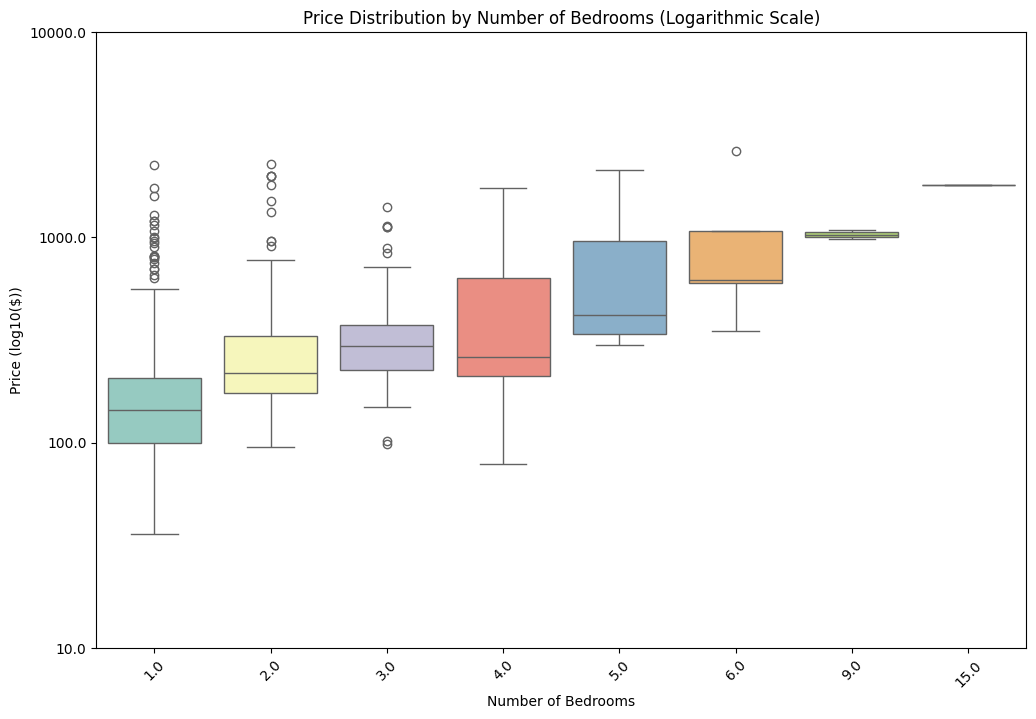

In [21]:
airbnb_data['scaled_price'] = np.log10(airbnb_data['price'])

plt.figure(figsize=(12, 8))
sns.boxplot(x='bedrooms', y='scaled_price', data=airbnb_data, palette='Set3')
plt.title('Price Distribution by Number of Bedrooms (Logarithmic Scale)')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Price (log10($))')
plt.xticks(rotation=45)  

tick_positions = np.arange(np.floor(airbnb_data['scaled_price'].min()), np.ceil(airbnb_data['scaled_price'].max()) + 1)
tick_labels = [10 ** i for i in tick_positions]
plt.yticks(tick_positions, tick_labels)

plt.show()

We can see that the distributions generally grow upwards as the number of bedrooms increases. Let's run a regression test for number of bedrooms against price.

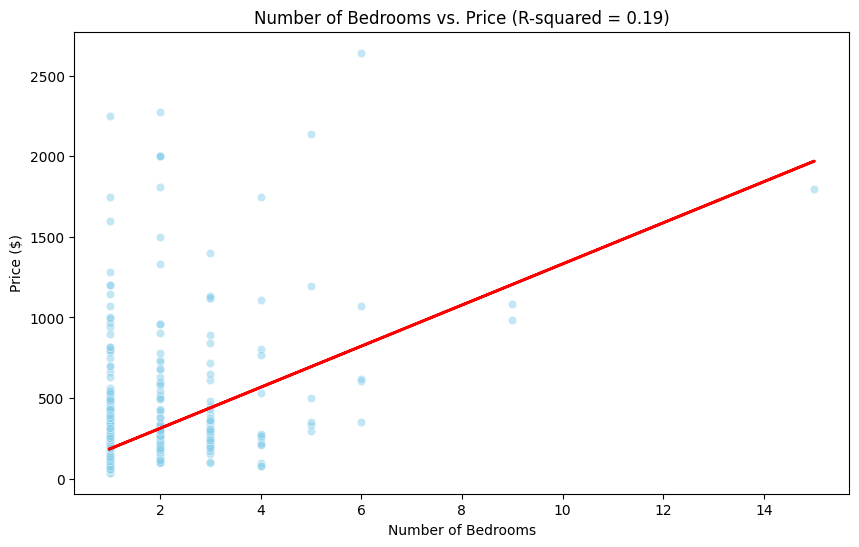

In [22]:
filtered_data = airbnb_data.dropna(subset=['bedrooms', 'price'])

X = filtered_data[['bedrooms']]
y = filtered_data['price']

model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='bedrooms', y='price', data=filtered_data, color='skyblue', alpha=0.5)

plt.plot(X, y_pred, color='red', linewidth=2)

r_squared = r2_score(y, y_pred)

plt.title(f"Number of Bedrooms vs. Price (R-squared = {r_squared:.2f})")
plt.xlabel('Number of Bedrooms')
plt.ylabel('Price ($)')
plt.show()


We can see that there is a positive correlation, but with an R^2 value of only 0.19, the correlation is not very strong and is not a very accurate predictor of price.

Let's continue by looking at the types of room and their individual distributions.

/var/folders/s9/z0q6n5_574qflfs18jklb0hr0000gn/T/ipykernel_32650/532478969.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='room_type', y='scaled_price', data=airbnb_data, palette='Set3')


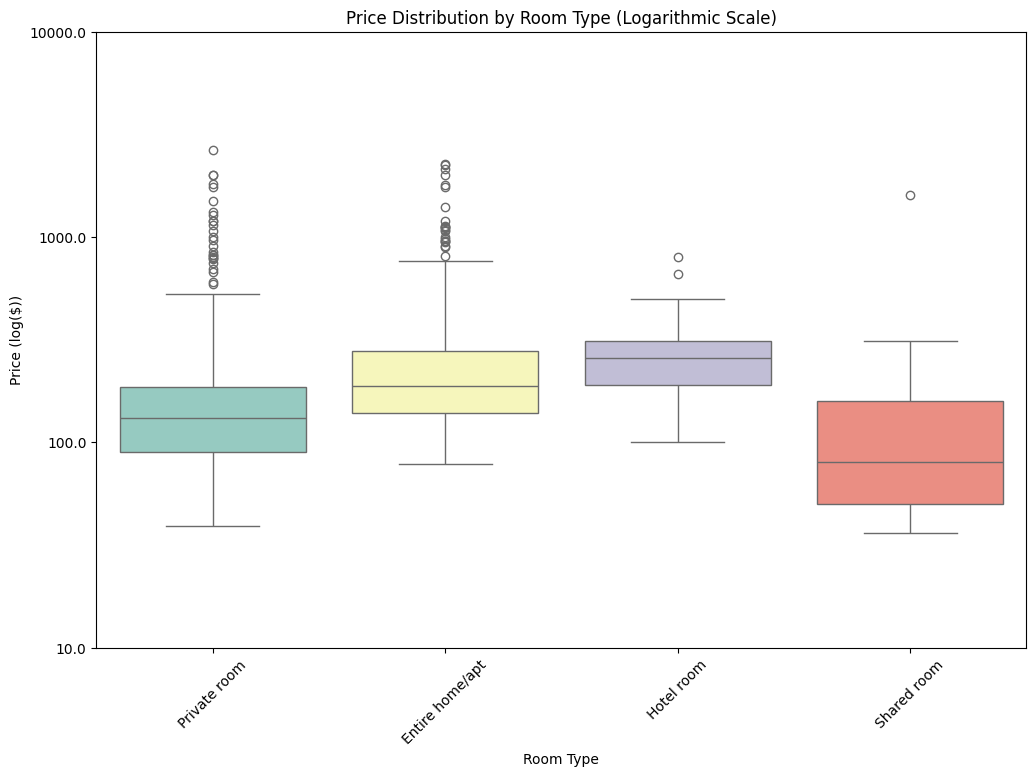

In [23]:
airbnb_data['scaled_price'] = np.log10(airbnb_data['price'])

plt.figure(figsize=(12, 8))
sns.boxplot(x='room_type', y='scaled_price', data=airbnb_data, palette='Set3')
plt.title('Price Distribution by Room Type (Logarithmic Scale)')
plt.xlabel('Room Type')
plt.ylabel('Price (log($))')
plt.xticks(rotation=45)

tick_positions = np.arange(np.floor(airbnb_data['scaled_price'].min()), np.ceil(airbnb_data['scaled_price'].max()) + 1)
tick_labels = [10 ** i for i in tick_positions]
plt.yticks(tick_positions, tick_labels)

plt.show()

We can see that the room type does cause the median and distribution of the prices to vary. 

A very important determinant of price is going to be location. We will take a look at how prices are distributed geographically across the city.

In [24]:
airbnb_data_clean = airbnb_data.dropna(subset=['latitude', 'longitude', 'price'])

map_center = [airbnb_data_clean['latitude'].mean(), airbnb_data_clean['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=11)

airbnb_data_clean['log_price'] = np.log(airbnb_data_clean['price'])

colormap = linear.RdYlGn_09.scale(airbnb_data_clean['log_price'].min(), airbnb_data_clean['log_price'].max())

for index, row in airbnb_data_clean.iterrows():
    folium.CircleMarker(location=[row['latitude'], row['longitude']], 
                        radius=5, 
                        color='black', 
                        fill=True,
                        fill_color=colormap(row['log_price']),
                        fill_opacity=0.9,
                        weight=1).add_to(m)  

colormap.caption = 'Log Price'
m.add_child(colormap)

m


This map tells us two things: How prices are distributed geographically and how our data is distributed geographically. It seems that most Airbnbs are in manhattan, but there isn't a very clear trend in pricing by location. 

Unfortunately with categorical data, determining a correlation value may prove to be difficult.

### Part 4: Advanced Analysis and Machine Learning / Regression

While some columns have correlations with price, putting multiple together to predict price should be more effective than using only one feature. To accomplish this we will create a machine learning model trained off of the neighborhood, property type, room type, and number of bedrooms. 

For this project, we decided to use a random forest regressor model which is a model that creates multiple descision trees and combines all of them to make a prediction.

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


airbnb_data = airbnb_data[columns_of_interest]

First, we will split our columns of interest into dummy columns. This way, each type of category will have it's own column that can be assesed by the model mathematically. Each column will contain a 1 or 0 value for each row to indicate whether that feature is present.

In [26]:
features = ['neighbourhood_cleansed', 'property_type', 'room_type', 'bedrooms']
target = 'price'

airbnb_data = airbnb_data[features + [target]]
airbnb_data['bedrooms'] = airbnb_data['bedrooms'].astype(str)

dummies = pd.get_dummies(airbnb_data, columns=['neighbourhood_cleansed', 'property_type', 'room_type', 'bedrooms'])

The next step is to split the data into training and testing data. This way, we can train our model on training data and apply it to the testing data to evaluate and score its accuracy.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(dummies[[x for x in list(dummies.columns) if x != target]], dummies[target], test_size=0.2, random_state=42)

Lastly, we will create a random forest regressor and fit it to our training data.

In [28]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

#### Evaluating the model

Next, we will run our model on the test data, compare it to the actual test data prices, and see how well it performed.

In [29]:
y_pred = rf_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)


Mean Absolute Error (MAE): 92.51035276942837
Mean Squared Error (MSE): 50299.75516356639
Root Mean Squared Error (RMSE): 224.27606908354355
R-squared (R2) Score: 0.325439683027237


These statistics provide insights into the performance of the predictive model. The Mean Absolute Error (MAE) represents the average absolute difference between the predicted and actual values. The Mean Squared Error (MSE) measures the average squared difference between predicted and actual values, emphasizing larger errors due to squaring. The Root Mean Squared Error (RMSE) is the square root of MSE, offering a measure of the typical deviation of the predicted values from the actual values. The R-squared (R2) score indicates the proportion of the variance in the dependent variable (price in this case) that is predictable from the independent variables (features). An R2 score of 0.33 suggests that about 33% of the variance in price can be explained by the features used in the model.

Next, let's take a look at the true prices of the test data vs the model's predicted prices.

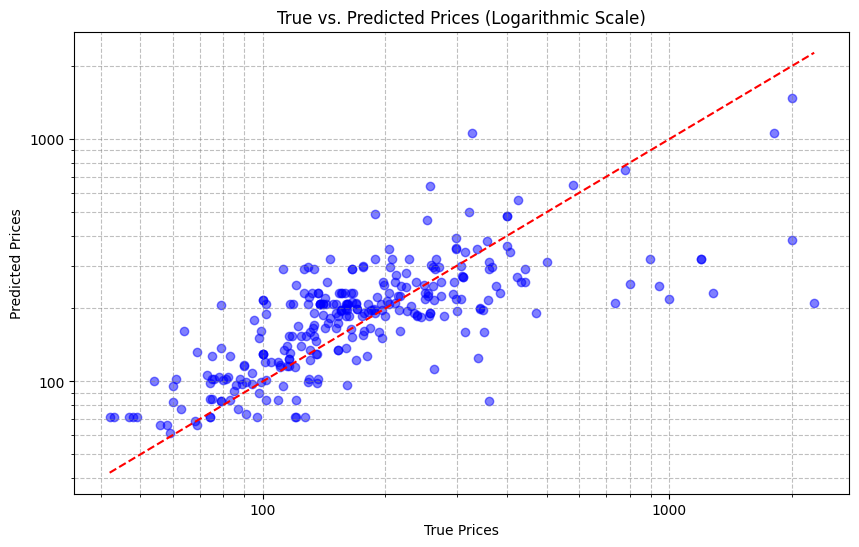

In [30]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('True vs. Predicted Prices (Logarithmic Scale)')
plt.xlabel('True Prices')
plt.ylabel('Predicted Prices')
plt.xscale('log')  
plt.yscale('log') 

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=10))
plt.gca().xaxis.set_minor_locator(ticker.LogLocator(base=10, subs=np.arange(2, 10)))
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
plt.gca().xaxis.set_minor_formatter(ticker.NullFormatter())

plt.gca().yaxis.set_major_locator(ticker.LogLocator(base=10))
plt.gca().yaxis.set_minor_locator(ticker.LogLocator(base=10, subs=np.arange(2, 10)))
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
plt.gca().yaxis.set_minor_formatter(ticker.NullFormatter())

plt.grid(True, which="both", ls="--", color='gray', alpha=0.5)  
plt.show()


We can see that the model is pretty closeley spread around the accurate prices. To further look into this, we can plot the residuals, or differences between true and predicted prices.

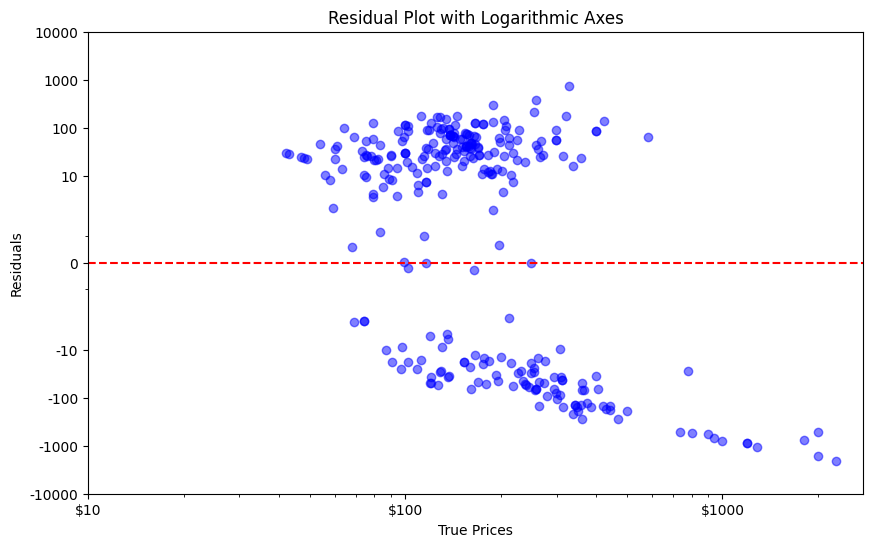

In [31]:
residuals = y_pred - y_test

plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, color='blue', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')  
plt.title('Residual Plot with Logarithmic Axes')
plt.xlabel('True Prices')
plt.ylabel('Residuals')
plt.xscale('log')  
plt.yscale('symlog')

tick_values = [10, 100, 1000] 
plt.xticks(tick_values, [f"${val}" for val in tick_values]) 


ticks = [-10000, -1000, -100, -10, 0, 10, 100, 1000, 10000]  
plt.gca().yaxis.set_major_formatter(ScalarFormatter())  
plt.yticks(ticks, ticks) 

plt.show()

We can see that the model is predicting both above and below true values evenly, falling off toward the low side towards higher priced properties. This is probably because the few outliers with high prices don't affect the model as much as the bulk of properties with lower prices.

Next, lets look at the feature importance plot. To create it, we have to aggregate the children columns from each feature back together to see the whole picture.

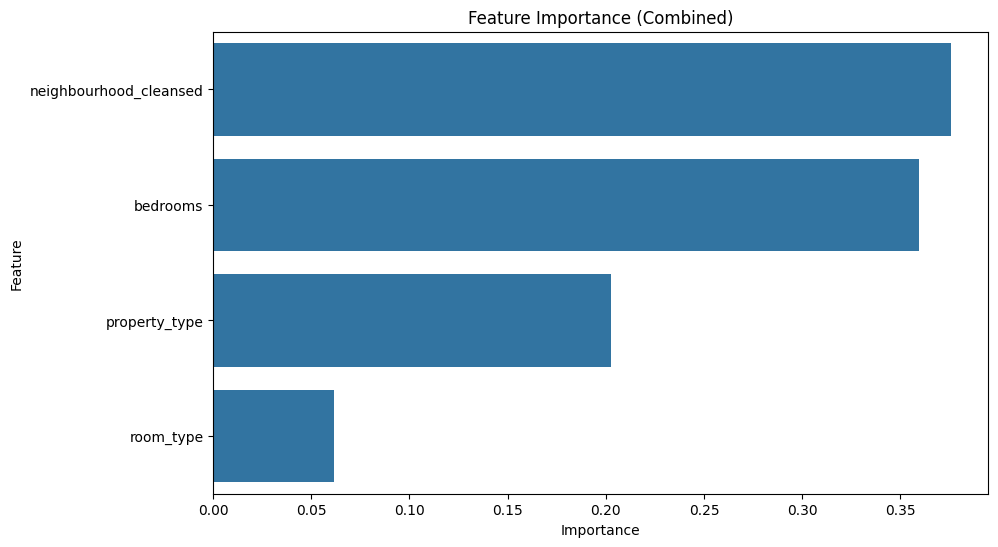

In [32]:
feature_importances = rf_model.feature_importances_

original_categorical_features = ['neighbourhood_cleansed', 'property_type', 'room_type', 'bedrooms']
combined_importances = {}
for i, feature in enumerate(original_categorical_features):
    related_indices = [idx - 1 for idx, col in enumerate(dummies.columns) if col.startswith(feature)]
    importance_sum = sum(feature_importances[idx] for idx in related_indices)
    combined_importances[feature] = importance_sum

combined_importances = {k: v for k, v in sorted(combined_importances.items(), key=lambda item: item[1], reverse=True)}

plt.figure(figsize=(10, 6))
sns.barplot(x=list(combined_importances.values()), y=list(combined_importances.keys()))
plt.title('Feature Importance (Combined)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


Looking at the plot, it seems like that the neighborhood is the most important feature in determining the price of airbnb listings. This makes sense because of "Location, Location, Location!". For a popular spot like New York City, tourists want to be close to downtown in walkable and safe areas.

### Part 5: Conclusion

Based on the analysis conducted, it's evident that our predictive model has some room for improvement. The Mean Absolute Error (MAE) of approximately 92.51 suggests that, on average, our model's predictions are off by around $92.51. The Mean Squared Error (MSE) and Root Mean Squared Error (RMSE) values of approximately 50,299.76 and 224.28, respectively, indicate that our model's predictions have a considerable variance from the actual values. Additionally, the R-squared (R2) score of approximately 0.33 indicates that our model explains only about 32.54% of the variance in the target variable.

Analyzing the feature importance reveals that the neighborhood and number of bedrooms are the most influential factors in predicting the price, with respective importance scores of about 0.4 and 0.35. Property type and room type also contribute to the model's predictions but to a lesser extent, with importance scores of 0.2 and 0.07, respectively.

In conclusion, while our model provides some insight into the factors influencing listing prices, there is still significant room for improvement. Further refinement of the model, possibly by incorporating additional features or exploring more advanced modeling techniques, may lead to better predictive performance. That said, it can still be used to gain insight to pricing future Airbnb listings and could help develop an idea of a price range.

#### Datasource

[Inside Airbnb](https://insideairbnb.com/get-the-data/)
